# Sentiment Analysis of Yelp Reviews

Yelp is a popular platform for user reviews for various brands, especially for restaurants and hotels. This application gathers the reviews for a specific brand in a specific City and by applying Natural Language Processing algorithm, provides Sentiment Analysis graphically.

### Data Sources

The main data source for this Sentiment Analysis program are Yelp APIs. There are 2 APIs that we are accessing here:
- Yelp Businesses API
- Yelp Reviews API


### High-level Approach
1. Prompt for the City where the Yelp reviews need to be pulled for. For example, Atlanta.
2. Prompt for the Brand Name for which the reviews need to be analyzed. For example, Mcdonalds.
3. Using the Yelp Business API, extract the location details of the brand in that city. For example, all Mcdonalds in Atlanta.
4. Then using the Yelp Reviews API, extract all the reviews for each of the locations extracted in Step 3.
5. Using Huggingface and other NLP libraries, perform Sentiment Analysis on the review text.
6. Present a graph of the top ranking Sentiments.

In [56]:
# Import Environment Dependencies
import tweepy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from config import api_key, api_key_secret, access_token,access_token_secret, client_id, client_secret, tmdb_key, Yelp_Key, Yelp_ID
from pprint import pprint
from emot.emo_unicode import UNICODE_EMOJI
from datetime import date
from datetime import timedelta
from config import gkey
import requests
import urllib
from urllib.request import urlopen
import json
import gmaps
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import pipeline
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')
import os.path

In [57]:
auth_str = 'Bearer '+ Yelp_Key 
import re

## Step 1 - Input Brand & City and Extract Brand Locations
- Prompt and get City and Brand to be analyzed
- Use Yelp Business API to extract all brand locations in the city
- Add these to a Panda Dataframe

In [76]:
stores = []

print("Enter City Name")
city = input()

city = city.upper()

print("Enter Brand Name")
brand = input()

brand = brand.upper()

url = "https://api.yelp.com/v3/businesses/search?location="

query_url = url + city + "&term="+ brand+"&sort_by=best_match&limit=30"

headers = {
    "accept": "application/json",
    "Authorization": auth_str
}

response = requests.get(query_url, headers=headers)

response_json = response.json()
try:
            i = 0
            for r in response_json['businesses']:
                sname = response_json['businesses'][i]['name']
                sname = sname.upper()
                if (len(response_json['businesses'][i]['alias']) > 0) and re.search(brand, sname):
                    Store_Name = response_json['businesses'][i]['alias']
                    Store_Chain_Name = response_json['businesses'][i]['name']
                    Store_Lat = response_json['businesses'][i]['coordinates']['latitude']
                    Store_Long = response_json['businesses'][i]['coordinates']['longitude']
                    current_record = [Store_Name, Store_Lat, Store_Long, Store_Chain_Name]
                    stores.append(current_record)
        
                i = i + 1

except IndexError:
        errors.append('Index Out of Range')    
    
storedf = pd.DataFrame(stores, columns=['Store_Name','Store_Lat', 'Store_Long','Store_Chain_Name'])

storedf = storedf.sort_values(by="Store_Name")
storedf

Enter City Name
atlanta
Enter Brand Name
regal


,Store_Name,Store_Lat,Store_Long,Store_Chain_Name
8,regal-arbor-place-douglasville,33.727774,-84.744450,Regal Arbor Place
0,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station
7,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon
9,regal-cherokee-woodstock-4,34.107690,-84.543130,Regal Cherokee
3,regal-hollywood-north-i-85-chamblee-4,33.870542,-84.276906,Regal Hollywood @ North I-85
6,regal-mall-of-georgia-buford,34.066820,-83.984650,Regal Mall Of Georgia
5,regal-medlock-crossing-and-rpx-duluth-3,34.017746,-84.193623,Regal Medlock Crossing & RPX
2,regal-perimeter-pointe-atlanta-4,33.932250,-84.349310,Regal Perimeter Pointe
4,regal-studio-atlanta,33.849719,-84.365488,Regal Studio
1,regal-tara-cinemas-atlanta-5,33.818900,-84.350800,Regal Tara Cinemas


## Step 2 - Extract Reviews 
- Use Yelp Review API to extract and display Star Rating and Review Text of the brand locations
- Add these to a Panda Dataframe

In [77]:
store_reviews = []

for row in storedf.itertuples():
    
    store_name = row.Store_Name
    store_lat = row.Store_Lat
    store_long = row.Store_Long
    store_chain_name = row.Store_Chain_Name 
    
    url = "https://api.yelp.com/v3/businesses/"
    
    query_url = url + store_name+ "/reviews?limit=50&sort_by=yelp_sort"

    headers = {
        "accept": "application/json",
        "Authorization": auth_str
    }

    
    response = requests.get(query_url, headers=headers)

    response_json = response.json()
    
#     pprint(response_json["reviews"])
    try:
                i = 0
                for r in response_json['reviews']:
                    if len(response_json['reviews'][i]['text']) > 0:
                        Store_Name = store_name
                        Store_Lat = store_lat
                        Store_Long = store_long
                        Store_Chain_Name = store_chain_name
                        Store_Review = response_json['reviews'][i]['text']
                        Store_Star_Rating = response_json['reviews'][i]['rating']
                        current_record = [Store_Name, Store_Lat, Store_Long, Store_Chain_Name,\
                                              Store_Star_Rating, Store_Review]
                        store_reviews.append(current_record)

                    i = i + 1

    except IndexError:
            errors.append('Index Out of Range')    

reviewdf = pd.DataFrame(store_reviews, columns=['Store_Name','Store_Lat', 'Store_Long',\
                                                    'Store_Chain_Name','Store_Star_Rating','Store_Review'])

reviewdf = reviewdf.sort_values(by="Store_Name")
reviewdf

,Store_Name,Store_Lat,Store_Long,Store_Chain_Name,Store_Star_Rating,Store_Review
0,regal-arbor-place-douglasville,33.727774,-84.744450,Regal Arbor Place,5,The movie theater was very spacious and clean....
1,regal-arbor-place-douglasville,33.727774,-84.744450,Regal Arbor Place,1,Just spokes to the manager Jim about my issue ...
2,regal-arbor-place-douglasville,33.727774,-84.744450,Regal Arbor Place,3,I have not been to Arbor Place Mall in years s...
3,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station,3,This theater is located within Atlantic Statio...
4,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station,5,I watched Fast X at this place.\nThe large scr...
5,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station,5,"This is my go-to movie theater, especially sin..."
6,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon,5,We saw Barbie the Movie at this theatre. Many...
7,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon,2,"Not a nice theater any more, makes Avalon seem..."
8,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon,3,I started going to this theater when it was ne...
9,regal-cherokee-woodstock-4,34.107690,-84.543130,Regal Cherokee,3,Seats are super comfy and I love the monthly s...


## Step 3 - Analyze Review Text and Assign Sentiment Score
- SentimentIntensistyAnalyzer function from the NTLK libraries is used assign a score based on the verbiage of the Review text.
- Depending on if the Score is > 0, Equal to 0 or < 0, we determine the Score Category as Positive, Neutral or Negative.
- The Score and the Score Category are added as columns to the dataframe.

In [78]:
sid = SentimentIntensityAnalyzer()
list1 = []
for i in reviewdf['Store_Review']:
    list1.append((sid.polarity_scores(str(i)))['compound'])

In [79]:
reviewdf['sentiment_vader'] = pd.Series(list1)

def sentiment_category(sentiment):
    label = ''
    if(sentiment>0):
        label = 'positive'
    elif(sentiment == 0):
        label = 'neutral'
    else:
        label = 'negative'
    return(label)

reviewdf['sentiment_category_vader'] = reviewdf['sentiment_vader'].apply(sentiment_category)

In [80]:
reviewdf

,Store_Name,Store_Lat,Store_Long,Store_Chain_Name,Store_Star_Rating,Store_Review,sentiment_vader,sentiment_category_vader
0,regal-arbor-place-douglasville,33.727774,-84.744450,Regal Arbor Place,5,The movie theater was very spacious and clean....,0.8450,positive
1,regal-arbor-place-douglasville,33.727774,-84.744450,Regal Arbor Place,1,Just spokes to the manager Jim about my issue ...,0.2617,positive
2,regal-arbor-place-douglasville,33.727774,-84.744450,Regal Arbor Place,3,I have not been to Arbor Place Mall in years s...,0.7809,positive
3,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station,3,This theater is located within Atlantic Statio...,-0.5719,negative
4,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station,5,I watched Fast X at this place.\nThe large scr...,0.7351,positive
5,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station,5,"This is my go-to movie theater, especially sin...",0.0000,neutral
6,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon,5,We saw Barbie the Movie at this theatre. Many...,0.8707,positive
7,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon,2,"Not a nice theater any more, makes Avalon seem...",0.5355,positive
8,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon,3,I started going to this theater when it was ne...,-0.6447,negative
9,regal-cherokee-woodstock-4,34.107690,-84.543130,Regal Cherokee,3,Seats are super comfy and I love the monthly s...,0.6187,positive


## Step 4 - Analyze Review Text Using BERT Model
- Using the Cardiff NLP model analyze the Review text and assign a Positive, Negative and Neutral score to it. 
- This is BERT (Bidirectional Encoder Representations from Transformers) and is trained on over 50M Tweets

In [81]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [82]:
scores = []
for i in reviewdf['Store_Review']:
    encoded_text = tokenizer(i, return_tensors='pt')
    output = model(**encoded_text)
    score = output[0][0].detach().numpy()
    score = softmax(score)
    scores_dict = {
        'roberta_neg' : score[0],
        'roberta_neu' : score[1],
        'roberta_pos' : score[2],
    }
    scores.append(scores_dict)

In [83]:
roberta_neg=[]
roberta_neu=[]
roberta_pos=[]

for i in scores:
    neg = i['roberta_neg']
    neu = i['roberta_neu']
    pos = i['roberta_pos']
    roberta_neg.append(neg)
    roberta_neu.append(neu)
    roberta_pos.append(pos)
    
reviewdf['roberta_neg'] = pd.Series(roberta_neg)
reviewdf['roberta_neu'] = pd.Series(roberta_neu)
reviewdf['roberta_pos'] = pd.Series(roberta_pos)

In [84]:
reviewdf

,Store_Name,Store_Lat,Store_Long,Store_Chain_Name,Store_Star_Rating,Store_Review,sentiment_vader,sentiment_category_vader,roberta_neg,roberta_neu,roberta_pos
0,regal-arbor-place-douglasville,33.727774,-84.744450,Regal Arbor Place,5,The movie theater was very spacious and clean....,0.8450,positive,0.001156,0.007991,0.990853
1,regal-arbor-place-douglasville,33.727774,-84.744450,Regal Arbor Place,1,Just spokes to the manager Jim about my issue ...,0.2617,positive,0.426741,0.535524,0.037735
2,regal-arbor-place-douglasville,33.727774,-84.744450,Regal Arbor Place,3,I have not been to Arbor Place Mall in years s...,0.7809,positive,0.005258,0.048148,0.946594
3,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station,3,This theater is located within Atlantic Statio...,-0.5719,negative,0.695169,0.236666,0.068165
4,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station,5,I watched Fast X at this place.\nThe large scr...,0.7351,positive,0.002368,0.074325,0.923307
5,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station,5,"This is my go-to movie theater, especially sin...",0.0000,neutral,0.002776,0.132009,0.865215
6,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon,5,We saw Barbie the Movie at this theatre. Many...,0.8707,positive,0.001931,0.045210,0.952859
7,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon,2,"Not a nice theater any more, makes Avalon seem...",0.5355,positive,0.908879,0.079347,0.011775
8,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon,3,I started going to this theater when it was ne...,-0.6447,negative,0.949098,0.047215,0.003687
9,regal-cherokee-woodstock-4,34.107690,-84.543130,Regal Cherokee,3,Seats are super comfy and I love the monthly s...,0.6187,positive,0.029528,0.110335,0.860137


## Step 5 - Find Underlying Emotion beneath the Review
- Using another BERT Model arpanghoshal/EmoRoBERTa to get the emotion/sentiment in the Review text.
- This model has been trained using Reddit comments
- It helps identify emotions such as - admiration, amusement, disapproval, disgust, relief etc. and even a Neutral emotion.
- This emotion is added as another column to the dataframe

In [85]:
emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [86]:
def get_emotion_label(text):
  return(emotion(text)[0]['label'])

In [87]:
reviewdf['Emotion'] = reviewdf['Store_Review'].apply(get_emotion_label)

In [88]:
reviewdf

,Store_Name,Store_Lat,Store_Long,Store_Chain_Name,Store_Star_Rating,Store_Review,sentiment_vader,sentiment_category_vader,roberta_neg,roberta_neu,roberta_pos,Emotion
0,regal-arbor-place-douglasville,33.727774,-84.744450,Regal Arbor Place,5,The movie theater was very spacious and clean....,0.8450,positive,0.001156,0.007991,0.990853,admiration
1,regal-arbor-place-douglasville,33.727774,-84.744450,Regal Arbor Place,1,Just spokes to the manager Jim about my issue ...,0.2617,positive,0.426741,0.535524,0.037735,neutral
2,regal-arbor-place-douglasville,33.727774,-84.744450,Regal Arbor Place,3,I have not been to Arbor Place Mall in years s...,0.7809,positive,0.005258,0.048148,0.946594,surprise
3,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station,3,This theater is located within Atlantic Statio...,-0.5719,negative,0.695169,0.236666,0.068165,annoyance
4,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station,5,I watched Fast X at this place.\nThe large scr...,0.7351,positive,0.002368,0.074325,0.923307,approval
5,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station,5,"This is my go-to movie theater, especially sin...",0.0000,neutral,0.002776,0.132009,0.865215,approval
6,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon,5,We saw Barbie the Movie at this theatre. Many...,0.8707,positive,0.001931,0.045210,0.952859,admiration
7,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon,2,"Not a nice theater any more, makes Avalon seem...",0.5355,positive,0.908879,0.079347,0.011775,disappointment
8,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon,3,I started going to this theater when it was ne...,-0.6447,negative,0.949098,0.047215,0.003687,disappointment
9,regal-cherokee-woodstock-4,34.107690,-84.543130,Regal Cherokee,3,Seats are super comfy and I love the monthly s...,0.6187,positive,0.029528,0.110335,0.860137,love


## Step 6 - Filter Out Neutral Reviews
- To ensure that we don't clutter the Sentiment Analysis with a bunch of Neutral Reviews, we filter those out.

In [89]:
finalreviewdf = reviewdf[reviewdf["Emotion"] != 'neutral'] 
finalreviewdf

,Store_Name,Store_Lat,Store_Long,Store_Chain_Name,Store_Star_Rating,Store_Review,sentiment_vader,sentiment_category_vader,roberta_neg,roberta_neu,roberta_pos,Emotion
0,regal-arbor-place-douglasville,33.727774,-84.744450,Regal Arbor Place,5,The movie theater was very spacious and clean....,0.8450,positive,0.001156,0.007991,0.990853,admiration
2,regal-arbor-place-douglasville,33.727774,-84.744450,Regal Arbor Place,3,I have not been to Arbor Place Mall in years s...,0.7809,positive,0.005258,0.048148,0.946594,surprise
3,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station,3,This theater is located within Atlantic Statio...,-0.5719,negative,0.695169,0.236666,0.068165,annoyance
4,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station,5,I watched Fast X at this place.\nThe large scr...,0.7351,positive,0.002368,0.074325,0.923307,approval
5,regal-atlantic-station-atlanta,33.793510,-84.396400,Regal Atlantic Station,5,"This is my go-to movie theater, especially sin...",0.0000,neutral,0.002776,0.132009,0.865215,approval
6,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon,5,We saw Barbie the Movie at this theatre. Many...,0.8707,positive,0.001931,0.045210,0.952859,admiration
7,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon,2,"Not a nice theater any more, makes Avalon seem...",0.5355,positive,0.908879,0.079347,0.011775,disappointment
8,regal-avalon-alpharetta-5,34.071910,-84.276617,Regal Avalon,3,I started going to this theater when it was ne...,-0.6447,negative,0.949098,0.047215,0.003687,disappointment
9,regal-cherokee-woodstock-4,34.107690,-84.543130,Regal Cherokee,3,Seats are super comfy and I love the monthly s...,0.6187,positive,0.029528,0.110335,0.860137,love
10,regal-cherokee-woodstock-4,34.107690,-84.543130,Regal Cherokee,2,I subscribe to Regal Unlimited card bc there i...,0.6369,positive,0.001760,0.016532,0.981707,love


## Step 7 - Plot Graph of Sentiments
- Plot a bar chart showing the Sentiments by Review Count
- The bar chart is sorted in the descending order of Number of Reviews
- The Sentiment with the highest number of Reviews is on the top.
- We can also generate a pie chart showing the distribution of the emotions across the reviews 

### Bar Chart

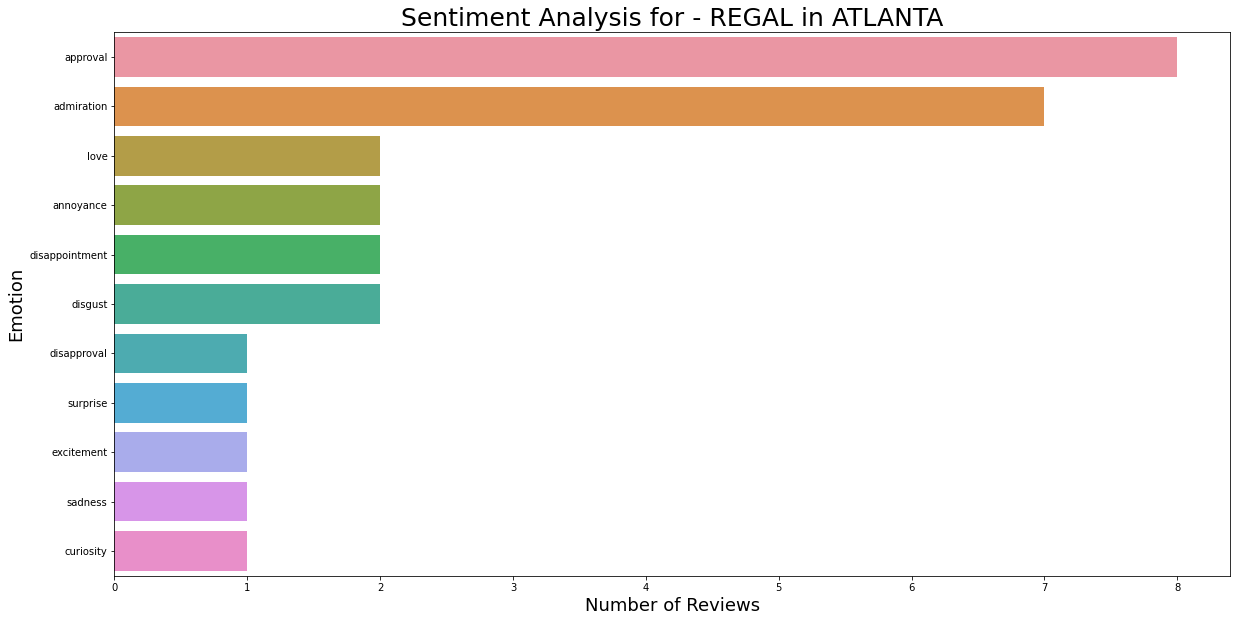

In [90]:
plt.figure(figsize = (20,10))
ax= sns.countplot(data = finalreviewdf, y = 'Emotion', order = finalreviewdf['Emotion'].value_counts().index)
ax.set_title("Sentiment Analysis for - "+ brand +" in "+city, fontsize = 25)
plt.xlabel("Number of Reviews",fontsize=18)
plt.ylabel("Emotion", fontsize=18)
plt.show()

### Pie Chart

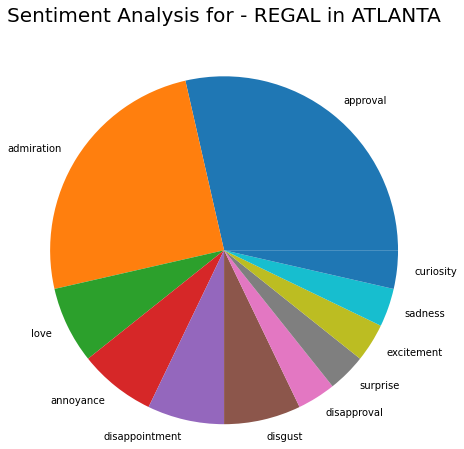

In [91]:
plt.title(label ="Sentiment Analysis for - "+ brand +" in "+city, fontdict={"fontsize":20},pad=120)

plt.pie(finalreviewdf['Emotion'].value_counts(), labels = finalreviewdf['Emotion'].value_counts().index, radius = 2)

plt.show()

## Step 8 - Save the Sentiment Analysis Data
- Save the Dataframe with the Sentiment Analysis to CSV file for future analytics
- The program first checks if the CSV file exists if it does the data is Appended else the file is created.

In [92]:
file_name = 'yelp_reviews_sentiment.csv'

check_file = os.path.isfile(file_name)

if check_file == True:
    finalreviewdf.to_csv(file_name, mode= 'a', sep=',', index=False, header=False)
else:
    finalreviewdf.to_csv(file_name, sep=',', index=False)
    